# Hyperparameter Optimized Dynamic Bert Model

In [ ]:
'''
Source: https://keras.io/guides/keras_tuner/getting_started/#tune-model-training
'''

In [1]:
import sys

# Append the directory containing the src folder to sys.path
sys.path.append('/Users/lars/Documents/test/')

In [2]:
from transformers import TFAutoModel
import keras_tuner
from keras_tuner.tuners import GridSearch
import random
import pandas as pd
import tensorflow as tf
import tensorflow_models as tfm
from transformers import AutoTokenizer, DataCollatorWithPadding, set_seed
from tensorflow.keras.callbacks import Callback # type: ignore
from datasets import Dataset
import os
import pickle
import time
from sklearn.metrics import f1_score, precision_score, recall_score
from src.data.data_manager import data_loader
from src.models.baseline_models import sort_by_length, create_buckets_and_batches_bert, BERTModelBuilderDynamic, MetricsCallbackDynamic

/Users/lars/Documents/test/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Path variables for datasets
directory = "/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift"
path_raw = "/data/raw/"
path_interim = "/data/interim/"
path_processed = "/data/processed/"

In [ ]:
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available: ", len(gpus))
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU available")

# Verify GPU utilization with a simple computation
with tf.device('/GPU:0'):
    a = tf.random.normal([10000, 10000])
    b = tf.random.normal([10000, 10000])
    start_time = time.time()
    c = tf.matmul(a, b)
    print("GPU computation time: ", time.time() - start_time, "seconds")

In [4]:
# Set seed for reproducability

tf.random.set_seed(1234)

In [5]:
train_tensor = data_loader(directory, path_interim, "Long_Helpdesk_train")
val_tensor = data_loader(directory, path_interim, "Long_Helpdesk_val")
test_tensor = data_loader(directory, path_interim, "Long_Helpdesk_test")

In [6]:
train_tensor

,Prefix_Trace,Next_Activity
0,assign-seriousness,take-in-charge-ticket
1,assign-seriousness take-in-charge-ticket,take-in-charge-ticket
2,assign-seriousness take-in-charge-ticket take-...,resolve-ticket
3,assign-seriousness take-in-charge-ticket take-...,closed
4,assign-seriousness take-in-charge-ticket take-...,end
...,...,...
13170,assign-seriousness,take-in-charge-ticket
13171,assign-seriousness take-in-charge-ticket,wait
13172,assign-seriousness take-in-charge-ticket wait,resolve-ticket
13173,assign-seriousness take-in-charge-ticket wait ...,closed


---
## Checking for Overfitting

### No Hyperparameter optimization

In [ ]:
# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Enable mixed precision for better performance and reduced memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

In [8]:
# Set parameters
num_classes = 10
batch_size = 4
max_length = 36  # Set the maximum sequence length

In [8]:
# Build and compile the model
model_builder = BERTModelBuilderDynamic(model_name='bert-base-uncased', num_classes=num_classes)
model = model_builder.create_model()
model.summary()

/Users/lars/Documents/test/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-07-02 10:27:45.707942: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-02 10:27:45.707964: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-02 10:27:45.707967: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-02 10:27:45.708000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-02 10:27:45.708013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/rep

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, None,                                        

In [16]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Dynamic padding and uniform length batching

# Assuming train_tensor and val_tensor are pandas dataframes
train_tensor['Prefix_Trace'] = train_tensor['Prefix_Trace'].astype(str)
val_tensor['Prefix_Trace'] = val_tensor['Prefix_Trace'].astype(str)

# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(train_tensor['Next_Activity'].unique())}
train_tensor['Next_Activity'] = train_tensor['Next_Activity'].map(label_map).astype(int)
val_tensor['Next_Activity'] = val_tensor['Next_Activity'].map(label_map).astype(int)

# Convert to Hugging Face datasets
train_data = Dataset.from_pandas(train_tensor)
val_data = Dataset.from_pandas(val_tensor)

# Sort the data by length
sorted_train_data = sort_by_length(train_data, tokenizer, max_length)
sorted_val_data = sort_by_length(val_data, tokenizer, max_length)

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Create TensorFlow datasets and ensure they repeat
tf_train_dataset = create_buckets_and_batches_bert(sorted_train_data, batch_size, data_collator).repeat()
tf_val_dataset = create_buckets_and_batches_bert(sorted_val_data, batch_size, data_collator).repeat()

# Prefetch datasets
tf_train_dataset = tf_train_dataset.prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch based on the length of the dataset
train_steps_per_epoch = len(sorted_train_data) // batch_size
val_steps_per_epoch = len(sorted_val_data) // batch_size

# Debugging statements to check the sizes and steps
print(f"Number of training samples: {len(sorted_train_data)}")
print(f"Number of validation samples: {len(sorted_val_data)}")
print(f"Steps per epoch (train): {train_steps_per_epoch}")
print(f"Steps per epoch (val): {val_steps_per_epoch}")

/Users/lars/Documents/test/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Number of training samples: 13175
Number of validation samples: 2805
Steps per epoch (train): 3293
Steps per epoch (val): 701


In [ ]:
# Set callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
metrics_callback = MetricsCallbackDynamic(validation_data=tf_val_dataset, steps_per_epoch=val_steps_per_epoch)

start_time = time.time()

# Train the model
history_helpdesk = model.fit(
    tf_train_dataset,
    epochs=50,  # Increase the number of epochs if necessary
    validation_data=tf_val_dataset,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=[metrics_callback, early_stopping_callback]
)

end_time = time.time()

print(f"BERT (base) training time: {end_time - start_time} seconds")

In [ ]:
history_save_dir = '/home/lars.gsaenger/test/models/models_pretrained/histories'

# Define the model and history file paths
history_save_path = os.path.join(history_save_dir, 'tuned_dynamic_bert_bpic2018_history.pkl')

# Save the history object returned by model.fit()
with open(history_save_path, 'wb') as f:
    pickle.dump(history_helpdesk.history, f)

print(f"History saved to {history_save_path}")

In [ ]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    # Extracting data from history
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Plotting training and validation loss and accuracy in subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting training and validation loss
    axs[0].plot(epochs, train_loss, 'b', label='Training Loss')
    axs[0].plot(epochs, val_loss, 'r', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting training and validation accuracy
    axs[1].plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    axs[1].plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()


In [ ]:
%matplotlib inline

# Assuming 'model_history' is the history object obtained after training the model
plot_model_history(history_helpdesk.history)

---
### Learning rate scheduler

In [ ]:
# Parameters

epochs = 5
learning_rate = 1e-5


In [14]:
steps_per_epoch = int(len(train_tensor['Prefix_Trace'])/batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1*num_train_steps)
#learning_rate = 5e-5

In [16]:
linear_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=num_train_steps, decay_rate=0.01)

In [17]:
warumup_schedule = tfm.optimization.lr_schedule.LinearWarmup(warmup_learning_rate=0, after_warmup_lr_sched=linear_decay, warmup_steps=warmup_steps)

In [38]:
import matplotlib.pyplot as plt

x = [i for i in range(0, num_train_steps)]
y = [warumup_schedule(xi).numpy() for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')


Text(0, 0.5, 'Learning rate')

In [18]:
import numpy as np
steps = np.arange(0, num_train_steps, 1)
lrs=[]

for step in steps:
    lrs.append(warumup_schedule(step))

In [12]:
import matplotlib.pyplot as plt

In [13]:
%matplotlib inline

In [45]:
lrs

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1496338e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.2992677e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.4489014e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.5985353e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.748169e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.8978028e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.0474365e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=9.197071e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0346705e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1496338e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.2645972e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.37956055e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.494524e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.6094873e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.7244508e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.839414

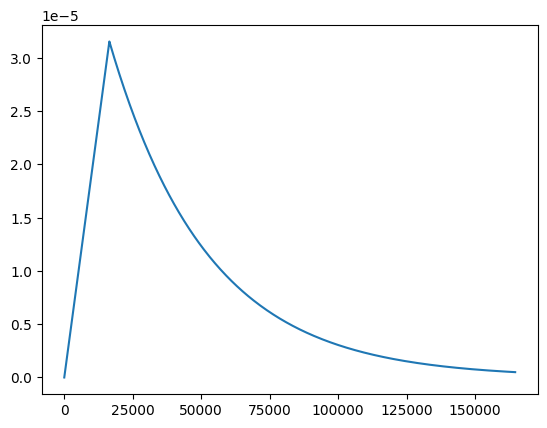

In [19]:
plt.plot(lrs)
plt.show()

In [22]:
optimzer = tf.keras.optimizers.experimental.AdamW(learning_rate=warumup_schedule)

---
## Tune Learning Rate

In [ ]:
# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Enable mixed precision for better performance and reduced memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

In [ ]:
# Set parameters
epochs = 5
batch_size = 32
num_classes = 10
max_length = 36

In [ ]:
# Adaped BERT model to tune learning rate

class BERTModelBuilderDynamic():
    def __init__(self, model_name, num_classes, batch_size, epochs):

        self.model_name = model_name
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.epochs = epochs

    def create_model(self, hp):

        # Load the pretrained BERT model
        encoder = TFAutoModel.from_pretrained(self.model_name)

        # Input layer for input_ids and attention_masks
        input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
        attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

        # Get encoder outputs
        encoder_outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Get the pooled output and make sure it is of type tf.float32
        pooled_output = tf.keras.layers.Lambda(lambda x: tf.cast(x.pooler_output, tf.float32))(encoder_outputs)

        # Apply dropout
        dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

        # Final dense layer for classification with softmax activation function and L2 regularization
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', dtype=tf.float32)(dropout)
        
        # Create model
        model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

        learning_rate = hp.Choice('learning_rate', values=[5e-5, 3e-5, 2e-5])

        steps_per_epoch = int(len(train_tensor['Prefix_Trace'])/self.batch_size)
        num_train_steps = steps_per_epoch * self.epochs
        warmup_steps = int(0.1*num_train_steps)

        linear_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=num_train_steps, decay_rate=0.01)
        optimizer = tfm.optimization.lr_schedule.LinearWarmup(warmup_learning_rate=0, after_warmup_lr_sched=linear_decay, warmup_steps=warmup_steps)

        # Compile model with AdamW as optimzer
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=optimizer),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        
        return model

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Dynamic padding and uniform length batching

# Assuming train_tensor and val_tensor are pandas dataframes
train_tensor['Prefix_Trace'] = train_tensor['Prefix_Trace'].astype(str)
val_tensor['Prefix_Trace'] = val_tensor['Prefix_Trace'].astype(str)
test_tensor['Prefix_Trace'] = test_tensor['Prefix_Trace'].astype(str)

# Convert labels to integers
label_map_train = {label: idx for idx, label in enumerate(train_tensor['Next_Activity'].unique())}
label_map_val = {label: idx for idx, label in enumerate(val_tensor['Next_Activity'].unique())}
label_map_test = {label: idx for idx, label in enumerate(test_tensor['Next_Activity'].unique())}
print(f"Train: {label_map_train}")
print(f"Val: {label_map_val}")
print(f"Test: {label_map_test}")
train_tensor['Next_Activity'] = train_tensor['Next_Activity'].map(label_map_train).astype(int)
val_tensor['Next_Activity'] = val_tensor['Next_Activity'].map(label_map_train).astype(int)
test_tensor['Next_Activity'] = test_tensor['Next_Activity'].map(label_map_train).astype(int)

# Convert to Hugging Face datasets
train_data = Dataset.from_pandas(train_tensor)
val_data = Dataset.from_pandas(val_tensor)
test_data = Dataset.from_pandas(test_tensor)

# Sort the data by length
sorted_train_data = sort_by_length(train_data, tokenizer, max_length)
sorted_val_data = sort_by_length(val_data, tokenizer, max_length)
sorted_test_data = sort_by_length(test_data, tokenizer, max_length)

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Create TensorFlow datasets and ensure they repeat
tf_train_dataset = create_buckets_and_batches_bert(sorted_train_data, batch_size, data_collator)
tf_val_dataset = create_buckets_and_batches_bert(sorted_val_data, batch_size, data_collator)
tf_test_dataset = create_buckets_and_batches_bert(sorted_test_data, batch_size, data_collator)

# Prefetch datasets
tf_train_dataset = tf_train_dataset.prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.prefetch(tf.data.AUTOTUNE)
tf_test_dataset = tf_test_dataset.prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch based on the length of the dataset
train_steps_per_epoch = len(sorted_train_data) // batch_size
val_steps_per_epoch = len(sorted_val_data) // batch_size
test_steps_per_epoch = len(sorted_test_data) // batch_size


# Debugging statements to check the sizes and steps
print(f"Number of training samples: {len(sorted_train_data)}")
print(f"Number of validation samples: {len(sorted_val_data)}")
print(f"Number of test samples: {len(sorted_test_data)}")
print(f"Steps per epoch (train): {train_steps_per_epoch}")
print(f"Steps per epoch (val): {val_steps_per_epoch}")
print(f"Steps per epoch (test): {test_steps_per_epoch}")


In [ ]:
# Initialize Class
model_builder = BERTModelBuilderDynamic(model_name='bert-base-uncased', num_classes=num_classes, batch_size=batch_size, epochs=epochs)

In [ ]:
tuner = GridSearch(
    model_builder.create_model,
    objective = 'val_loss',
    max_trials = 15,
    executions_per_trial = 1,
    directory="Hyperparameter",
    project_name="learning_rate_Helpdesk_v2",
)

In [ ]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(tf_train_dataset, epochs = epochs, validation_data = tf_val_dataset, callbacks=[early_stopping], steps_per_epoch=train_steps_per_epoch, validation_steps=val_steps_per_epoch)

In [ ]:
best_lr = tuner.get_best_hyperparameters(num_trials=1)[0]
lr = best_lr.get('learning_rate')

# Save best learning rate as txt file
with open('/home/lars.gsaenger/test/notebooks/best_learning_rate.txt', 'w') as f:
    f.write(f"Best Learning Rate: {lr}")

In [ ]:
# Print results
tuner.results_summary()

---
## Tune Batch Size

In [ ]:
# Set parameters
epochs = 5
num_classes = 10
max_length = 36

In [ ]:
batch_size_list = [8, 16]

In [ ]:
# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Enable mixed precision for better performance and reduced memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

In [ ]:
# BERT Base model adjusted with fine-tuned learning rate

class BERTModelBuilderDynamic():
    def __init__(self, model_name, num_classes, batch_size, epochs):

        self.model_name = model_name
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.epochs = epochs

    def create_model(self):

        # Load the pretrained BERT model
        encoder = TFAutoModel.from_pretrained(self.model_name)

        # Input layer for input_ids and attention_masks
        input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
        attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

        # Get encoder outputs
        encoder_outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Get the pooled output and make sure it is of type tf.float32
        pooled_output = tf.keras.layers.Lambda(lambda x: tf.cast(x.pooler_output, tf.float32))(encoder_outputs)

        # Apply dropout
        dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

        # Final dense layer for classification with softmax activation function and L2 regularization
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', dtype=tf.float32)(dropout)
        
        # Create model
        model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

        steps_per_epoch = int(len(train_tensor['Prefix_Trace'])/self.batch_size)
        num_train_steps = steps_per_epoch * self.epochs
        warmup_steps = int(0.1*num_train_steps)

        linear_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-05, decay_steps=num_train_steps, decay_rate=0.01)
        optimizer = tfm.optimization.lr_schedule.LinearWarmup(warmup_learning_rate=0, after_warmup_lr_sched=linear_decay, warmup_steps=warmup_steps)

        # Compile model with AdamW as optimzer
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=optimizer),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        
        return model

In [ ]:
batch_size_dict = {}
evaluation_dict = {}

for batch_size in batch_size_list:
    print(f"Current Batch Size: {batch_size}")
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    # Dynamic padding and uniform length batching

    # Assuming train_tensor and val_tensor are pandas dataframes
    train_tensor['Prefix_Trace'] = train_tensor['Prefix_Trace'].astype(str)
    val_tensor['Prefix_Trace'] = val_tensor['Prefix_Trace'].astype(str)
    test_tensor['Prefix_Trace'] = test_tensor['Prefix_Trace'].astype(str)

    # Convert labels to integers
    label_map = {label: idx for idx, label in enumerate(train_tensor['Next_Activity'].unique())}
    train_tensor['Next_Activity'] = train_tensor['Next_Activity'].map(label_map).astype(int)
    val_tensor['Next_Activity'] = val_tensor['Next_Activity'].map(label_map).astype(int)
    test_tensor['Next_Activity'] = test_tensor['Next_Activity'].map(label_map).astype(int)

    # Convert to Hugging Face datasets
    train_data = Dataset.from_pandas(train_tensor)
    val_data = Dataset.from_pandas(val_tensor)
    test_data = Dataset.from_pandas(test_tensor)

    # Sort the data by length
    sorted_train_data = sort_by_length(train_data, tokenizer, max_length)
    sorted_val_data = sort_by_length(val_data, tokenizer, max_length)
    sorted_test_data = sort_by_length(test_data, tokenizer, max_length)

    # Initialize data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

    # Create TensorFlow datasets and ensure they repeat
    tf_train_dataset = create_buckets_and_batches_bert(sorted_train_data, batch_size, data_collator)
    tf_val_dataset = create_buckets_and_batches_bert(sorted_val_data, batch_size, data_collator)
    tf_test_dataset = create_buckets_and_batches_bert(sorted_test_data, batch_size, data_collator)

    # Prefetch datasets
    tf_train_dataset = tf_train_dataset.prefetch(tf.data.AUTOTUNE)
    tf_val_dataset = tf_val_dataset.prefetch(tf.data.AUTOTUNE)
    tf_test_dataset = tf_test_dataset.prefetch(tf.data.AUTOTUNE)

    # Calculate steps per epoch based on the length of the dataset
    train_steps_per_epoch = len(sorted_train_data) // batch_size
    val_steps_per_epoch = len(sorted_val_data) // batch_size
    test_steps_per_epoch = len(sorted_test_data) // batch_size


    # Debugging statements to check the sizes and steps
    print(f"Number of training samples: {len(sorted_train_data)}")
    print(f"Number of validation samples: {len(sorted_val_data)}")
    print(f"Number of test samples: {len(sorted_test_data)}")
    print(f"Steps per epoch (train): {train_steps_per_epoch}")
    print(f"Steps per epoch (val): {val_steps_per_epoch}")
    print(f"Steps per epoch (test): {test_steps_per_epoch}")

    # Build and compile the model
    model_builder = BERTModelBuilderDynamic(model_name='bert-base-uncased', num_classes=num_classes, batch_size=batch_size, epochs=epochs)
    model = model_builder.create_model()
    model.summary()

    # Set callbacks
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    metrics_callback = MetricsCallbackDynamic(validation_data=tf_val_dataset, steps_per_epoch=val_steps_per_epoch)

    start_time = time.time()

    # Train the model
    history_helpdesk = model.fit(
        tf_train_dataset,
        epochs=epochs,  # Increase the number of epochs if necessary
        validation_data=tf_val_dataset,
        steps_per_epoch=train_steps_per_epoch,
        validation_steps=val_steps_per_epoch,
        callbacks=[metrics_callback, early_stopping_callback]
    )

    end_time = time.time()

    print(f"BERT (base) training time: {end_time - start_time} seconds")

    evaluation = model.evaluate(tf_test_dataset, steps=test_steps_per_epoch)

    batch_size_dict[batch_size] = history_helpdesk.history
    evaluation_dict[batch_size] = evaluation

    print(f"Loss for batch size {batch_size}: {evaluation[0]}")
    print(f"Accuracy for batch size {batch_size}: {evaluation[1]}")


---
## Fit final model and save weights

In [ ]:
# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Enable mixed precision for better performance and reduced memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

In [ ]:
# Set parameters
num_classes = 42
batch_size = 16
max_length = 242
epochs = 5

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Dynamic padding and uniform length batching

# Assuming train_tensor and val_tensor are pandas dataframes
train_tensor['Prefix_Trace'] = train_tensor['Prefix_Trace'].astype(str)
val_tensor['Prefix_Trace'] = val_tensor['Prefix_Trace'].astype(str)
test_tensor['Prefix_Trace'] = test_tensor['Prefix_Trace'].astype(str)

# Convert labels to integers
label_map_train = {label: idx for idx, label in enumerate(train_tensor['Next_Activity'].unique())}
label_map_val = {label: idx for idx, label in enumerate(val_tensor['Next_Activity'].unique())}
label_map_test = {label: idx for idx, label in enumerate(test_tensor['Next_Activity'].unique())}
train_tensor['Next_Activity'] = train_tensor['Next_Activity'].map(label_map_train).astype(int)
val_tensor['Next_Activity'] = val_tensor['Next_Activity'].map(label_map_train).astype(int)
test_tensor['Next_Activity'] = test_tensor['Next_Activity'].map(label_map_train).astype(int)

# Convert to Hugging Face datasets
train_data = Dataset.from_pandas(train_tensor)
val_data = Dataset.from_pandas(val_tensor)
test_data = Dataset.from_pandas(test_tensor)

# Sort the data by length
sorted_train_data = sort_by_length(train_data, tokenizer, max_length)
sorted_val_data = sort_by_length(val_data, tokenizer, max_length)
sorted_test_data = sort_by_length(test_data, tokenizer, max_length)

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Create TensorFlow datasets and ensure they repeat
tf_train_dataset = create_buckets_and_batches_bert(sorted_train_data, batch_size, data_collator)
tf_val_dataset = create_buckets_and_batches_bert(sorted_val_data, batch_size, data_collator)
tf_test_dataset = create_buckets_and_batches_bert(sorted_test_data, batch_size, data_collator)

# Prefetch datasets
tf_train_dataset = tf_train_dataset.prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.prefetch(tf.data.AUTOTUNE)
tf_test_dataset = tf_test_dataset.prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch based on the length of the dataset
train_steps_per_epoch = len(sorted_train_data) // batch_size
val_steps_per_epoch = len(sorted_val_data) // batch_size
test_steps_per_epoch = len(sorted_test_data) // batch_size


# Debugging statements to check the sizes and steps
print(f"Number of training samples: {len(sorted_train_data)}")
print(f"Number of validation samples: {len(sorted_val_data)}")
print(f"Number of test samples: {len(sorted_test_data)}")
print(f"Steps per epoch (train): {train_steps_per_epoch}")
print(f"Steps per epoch (val): {val_steps_per_epoch}")
print(f"Steps per epoch (test): {test_steps_per_epoch}")

In [ ]:
class MetricsCallbackDynamic(Callback):
    '''
    Custom callback for calculating, printing, and storing F1 Score, Precision, and Recall at the end of each epoch during training.
    '''

    def __init__(self, validation_data, steps_per_epoch):
        super().__init__()
        self.validation_data = validation_data
        self.steps_per_epoch = steps_per_epoch
        # Initialize lists to store the metrics
        self.f1_scores = []
        self.precisions = []
        self.recalls = []

    def on_epoch_end(self, epoch, logs=None):
        val_pred = []
        val_true = []

        # Process each batch in validation dataset
        for step, (x_val, y_val) in enumerate(self.validation_data.take(self.steps_per_epoch)):
            y_pred = self.model.predict(x_val, verbose=0)
            y_pred = tf.argmax(y_pred, axis=1)

            # Accumulate predictions and true labels
            val_pred.extend(y_pred.numpy())
            val_true.extend(y_val.numpy())

        # Calculate metrics
        f1 = f1_score(val_true, val_pred, average='weighted')
        precision = precision_score(val_true, val_pred, average='weighted', zero_division=0)
        recall = recall_score(val_true, val_pred, average='weighted', zero_division=0)

        # Store metrics
        self.f1_scores.append(f1)
        self.precisions.append(precision)
        self.recalls.append(recall)

        # Print metrics
        print(f' — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}')

        # Optionally, add these metrics to the logs dictionary
        logs['val_f1'] = f1
        logs['val_precision'] = precision
        logs['val_recall'] = recall

In [ ]:
class BERTModelBuilderDynamic():
    def __init__(self, model_name, num_classes, batch_size, epochs):

        self.model_name = model_name
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.epochs = epochs

    def create_model(self):

        # Load the pretrained BERT model
        encoder = TFAutoModel.from_pretrained(self.model_name)

        # Input layer for input_ids and attention_masks
        input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
        attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

        # Get encoder outputs
        encoder_outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Get the pooled output and make sure it is of type tf.float32
        pooled_output = tf.keras.layers.Lambda(lambda x: tf.cast(x.pooler_output, tf.float32))(encoder_outputs)

        # Apply dropout
        dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

        # Final dense layer for classification with softmax activation function
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', dtype=tf.float32)(dropout)
        
        # Create model
        model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

        steps_per_epoch = int(len(train_tensor['Prefix_Trace'])/self.batch_size)
        num_train_steps = steps_per_epoch * self.epochs
        warmup_steps = int(0.1*num_train_steps)

        linear_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-5, decay_steps=num_train_steps, decay_rate=0.01)
        optimizer = tfm.optimization.lr_schedule.LinearWarmup(warmup_learning_rate=0, after_warmup_lr_sched=linear_decay, warmup_steps=warmup_steps)

        # Compile model with AdamW as optimzer
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=optimizer),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        
        return model

In [ ]:
# Build and compile the model
model_builder = BERTModelBuilderDynamic(model_name='bert-base-uncased', num_classes=num_classes, batch_size=batch_size, epochs=epochs)
model = model_builder.create_model()
model.summary()

In [ ]:
# Set callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
metrics_callback = MetricsCallbackDynamic(validation_data=tf_val_dataset, steps_per_epoch=val_steps_per_epoch)

start_time = time.time()

# Train the model
history_helpdesk = model.fit(
    tf_train_dataset,
    epochs=5,  # Increase the number of epochs if necessary
    validation_data=tf_val_dataset,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=[metrics_callback, early_stopping_callback]
)

end_time = time.time()

print(f"BERT (base) training time: {end_time - start_time} seconds")

In [ ]:
# Save model weights

model_save_path = '/home/lars.gsaenger/test/models/Weights_BPIC2018_Tuned/Weights_BPIC2018_Tuned'
model.save_weights(model_save_path)

In [ ]:
# Directories to save the model and history
history_save_dir = '/home/lars.gsaenger/test/models/models_pretrained/histories'

# Define the model and history file paths
history_save_path = os.path.join(history_save_dir, 'tuned_dynamic_bert_bpic2018_history.pkl')

# Save the history object returned by model.fit()
with open(history_save_path, 'wb') as f:
    pickle.dump(history_helpdesk.history, f)

print(f"History saved to {history_save_path}")


In [ ]:
history_save_path = '/home/lars.gsaenger/test/models/models_pretrained/histories/tuned_dynamic_bert_bpic2018_history.pkl'

# Load the history object
with open(history_save_path, 'rb') as f:
    loaded_history = pickle.load(f)

In [ ]:
loaded_history

---
## Evaluate Model

In [ ]:
# Set up model structure again for reloading weights

class BERTModelBuilderDynamic():
    def __init__(self, model_name, num_classes, batch_size, epochs):

        self.model_name = model_name
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.epochs = epochs

    def create_model(self):

        # Load the pretrained BERT model
        encoder = TFAutoModel.from_pretrained(self.model_name)

        # Input layer for input_ids and attention_masks
        input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
        attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

        # Get encoder outputs
        encoder_outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Get the pooled output and make sure it is of type tf.float32
        pooled_output = tf.keras.layers.Lambda(lambda x: tf.cast(x.pooler_output, tf.float32))(encoder_outputs)

        # Apply dropout
        dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

        # Final dense layer for classification with softmax activation function
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', dtype=tf.float32)(dropout)
        
        # Create model
        model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

        steps_per_epoch = int(len(train_tensor['Prefix_Trace'])/self.batch_size)
        num_train_steps = steps_per_epoch * self.epochs
        warmup_steps = int(0.1*num_train_steps)

        linear_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-05, decay_steps=num_train_steps, decay_rate=0.01)
        optimizer = tfm.optimization.lr_schedule.LinearWarmup(warmup_learning_rate=0, after_warmup_lr_sched=linear_decay, warmup_steps=warmup_steps)

        # Compile model with AdamW as optimzer
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=optimizer),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        
        return model

In [ ]:
# Build and compile the model
test = BERTModelBuilderDynamic(model_name='bert-base-uncased', num_classes=num_classes, batch_size=batch_size, epochs=epochs)
test = test.create_model()

In [ ]:
# Load the weights into model

weights_load_path = '/home/lars.gsaenger/test/models/Weights_BPIC2012_Tuned/Weights_BPIC2012_Tuned'
test.load_weights(weights_load_path)

In [ ]:
# Test if everything worked
evaluation = test.evaluate(tf_test_dataset, steps=test_steps_per_epoch)

print(f"Validation loss: {evaluation[0]}")
print(f"Validation accuracy: {evaluation[1]}")

# Make predictions on a test dataset (optional)
predictions = test.predict(tf_test_dataset, steps=test_steps_per_epoch)